In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import bootstrap
import warnings
warnings.filterwarnings('ignore')

<h4>Data Collection and processing</h4>

In [2]:
df = pd.read_csv("../data/revenue_ab_test.csv")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.shape

(10000, 3)

In [4]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

With 10,000 entries, we see in this cell that there are only 6,324 unique user ID values. This means that there are multiple entries for certain users in the dataset. First, we aim to combine all of this data under a singular row.

In [5]:
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

No null values in the data so we can proceed towards combing through the data.

In [6]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

We see that there are 1,541 users who are part of both the test groups. These data points will blur the experiment results, so we intend to omit this data in order to get more accurate results, since we want to maintain independence between both test groups.

In [7]:
single_test_group = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_test_group = single_test_group[single_test_group]

Now, we only take the records with index values corresponding to users in just 1 of the test groups.

In [8]:
final_df = df[df['USER_ID'].isin(single_test_group.index)]
final_df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0]

True

In [9]:
final_df.shape

(6070, 3)

We managed to reduce the size of the dataset from 10,000 to 6,070. Now, we aim to observe the distribution of the data.

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

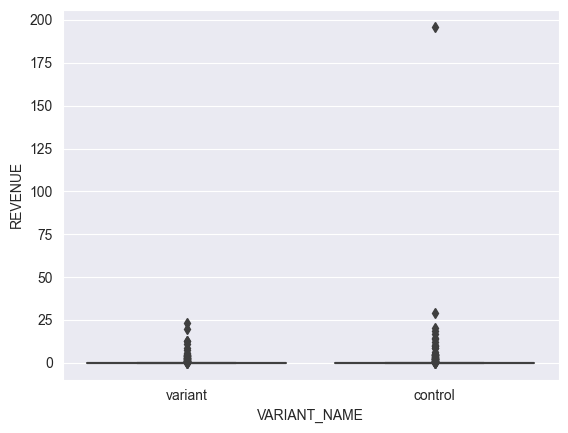

In [10]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=final_df)

There is evidently an outlier in this data, we aim to find this datapoint and study it.

In [11]:
final_df.sort_values(by='REVENUE', ascending=False)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
...,...,...,...
3366,1189,control,0.00
3363,2051,variant,0.00
3362,3276,variant,0.00
3360,1608,variant,0.00


User 3342 is the outlier in this case.

In [12]:
final_df[final_df['USER_ID']==3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


There seems to be just one outlier and hence, we remove this entry and take a look at the data distribution once again.

In [13]:
final_df = final_df[final_df['USER_ID']!=3342]

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

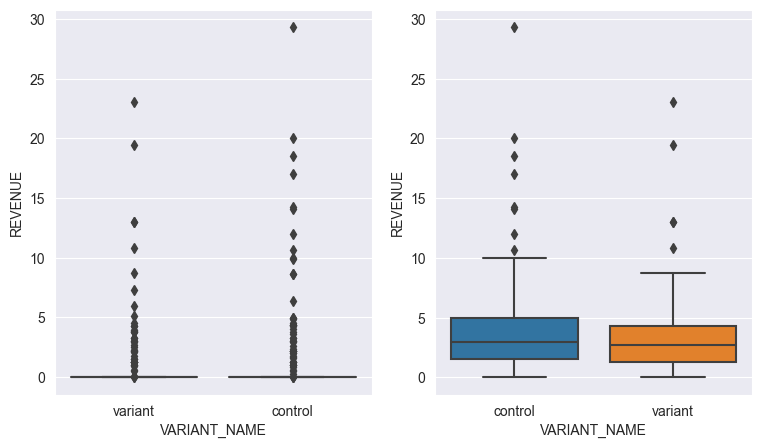

In [14]:
f, ax = plt.subplots(1,2, figsize=(9,5))
sns.boxplot(ax= ax[0], x='VARIANT_NAME', y='REVENUE', data=final_df)
sns.boxplot(ax = ax[1], x='VARIANT_NAME', y='REVENUE', data=final_df[final_df['REVENUE']>0])

It can be concluded that most users seem to be non-paying. However, some users might have multiple entries; some of them being empty purchases.

In [15]:
final_df.loc[
    (final_df['REVENUE']==0) &
    (final_df['USER_ID'].isin(final_df.loc[final_df['REVENUE']> 0, 'USER_ID'].values)),
    'USER_ID'
].count()

52

There are 52 users who have empty purchases and actual purchases simultaneously. Hence, we take a sum of the revenue per user on the basis of their user ID.

In [16]:
final_df = final_df.groupby(['USER_ID', 'VARIANT_NAME']).sum().reset_index()

In [17]:
final_df.shape

(4782, 3)

<AxesSubplot: xlabel='VARIANT_NAME', ylabel='REVENUE'>

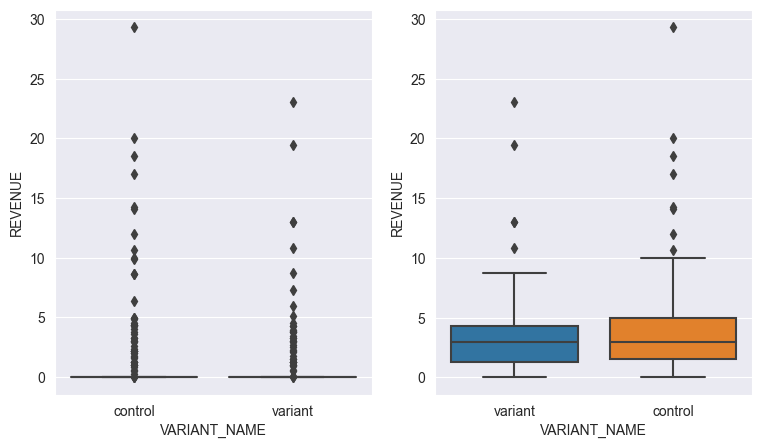

In [18]:
f, ax = plt.subplots(1,2, figsize=(9,5))
sns.boxplot(ax = ax[0], x='VARIANT_NAME', y='REVENUE', data = final_df)
sns.boxplot(ax = ax[1], x='VARIANT_NAME', y='REVENUE', data = final_df[final_df['REVENUE']>0])

For the variant test group, the quantiles have increased after the operations undertaken.

In [19]:
total_metrics = final_df.groupby(by='VARIANT_NAME').agg({
    'USER_ID': 'nunique',
    'REVENUE': ['sum', 'mean', 'median', 'count']})
total_metrics

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control         2389  274.55  0.114923    0.0  2389
variant         2393  179.32  0.074935    0.0  2393

Compared to the control group, the variant group has a lower total revenue output and mean. Looking at the median per group, there are a lot of non-paying users. Hence, we aim to look only at the paying users next.

In [20]:
paying_users = final_df.loc[final_df['REVENUE']!=0]

In [21]:
paying_users_metrics = paying_users.groupby(by='VARIANT_NAME').agg({
    'USER_ID': 'nunique',
    'REVENUE': ['sum', 'mean', 'median', 'count']
})
paying_users_metrics

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control           53  274.55  5.180189   2.99    53
variant           42  179.32  4.269524   2.97    42

We see that there are a mere 95 paying users relative to the entire sample size. There is a significant decrease in the net revenue in the case of the variant test group. We aim to assess the statistical significance of this decrease in revenue in the next section.

<h4>Statistical Analysis</h4>

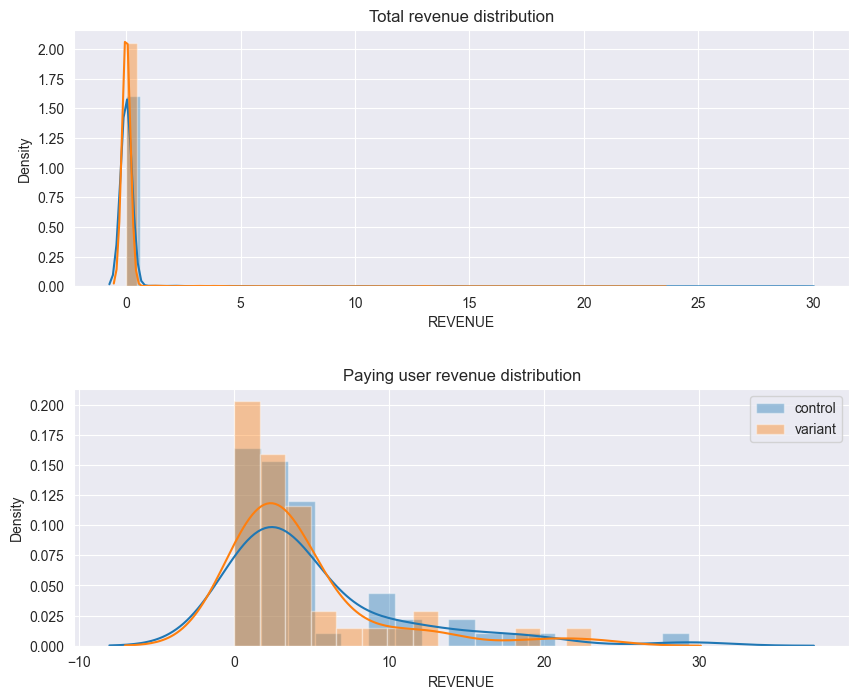

In [22]:
f, ax = plt.subplots(2, figsize=(10,8))
sns.distplot(final_df.loc[final_df['VARIANT_NAME'] == 'control', 'REVENUE'], ax=ax[0], label='control')
sns.distplot(final_df.loc[final_df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax=ax[0], label='variant')
ax[0].set_title('Total revenue distribution')
sns.distplot(final_df.loc[(final_df['VARIANT_NAME'] == 'control') & (final_df['REVENUE'] > 0), 'REVENUE'], ax=ax[1], label='control')
sns.distplot(final_df.loc[(final_df['VARIANT_NAME'] == 'variant') & (final_df['REVENUE'] > 0), 'REVENUE'], ax=ax[1], label='variant')
ax[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace=0.4)

The graphs above clearly show a non-Gaussian distribution due to the skewness and asymmetrical nature of the curve.

We now create a bootstrap sample to plot the sampling distribution for both: the total revenue and paying user revenue.

In [23]:
def get_bootstrap(data, n_samples=9999):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [24]:
control_total = get_bootstrap(final_df.loc[final_df['VARIANT_NAME'] == 'control', 'REVENUE'].values)
variant_total = get_bootstrap(final_df.loc[final_df['VARIANT_NAME'] == 'variant', 'REVENUE'].values)
control_paid = get_bootstrap(final_df.loc[(final_df['VARIANT_NAME'] == 'control') & (final_df['REVENUE'] > 0), 'REVENUE'].values)
variant_paid = get_bootstrap(final_df.loc[(final_df['VARIANT_NAME'] == 'variant') & (final_df['REVENUE'] > 0), 'REVENUE'].values)

Text(0.5, 1.0, 'Paying user sample mean distribution')

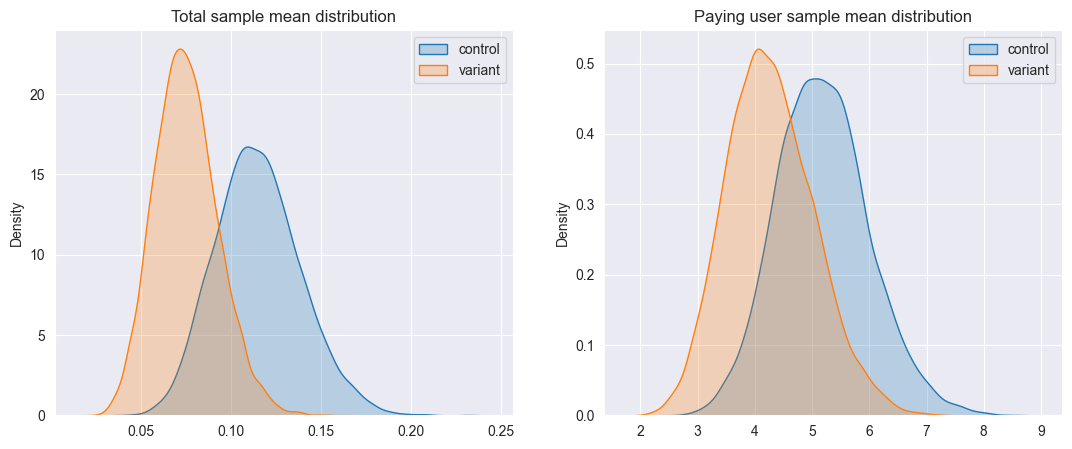

In [25]:
f, ax = plt.subplots(1,2, figsize=(13,5))
sns.kdeplot(np.mean(control_total, axis=1), fill=True, label='control', ax=ax[0])
sns.kdeplot(np.mean(variant_total, axis=1), fill=True, label='variant', ax=ax[0])
sns.kdeplot(np.mean(control_paid, axis=1), fill=True, label='control', ax=ax[1])
sns.kdeplot(np.mean(variant_paid, axis=1), fill=True, label='variant', ax=ax[1])
ax[0].legend()
ax[0].set_title('Total sample mean distribution')
ax[1].legend()
ax[1].set_title('Paying user sample mean distribution')

Although there is a visible difference in both the samples, there may be an overlap of confidence intervals, so we proceed towards looking at the difference in means between both groups.

In [26]:
mean_diff_total = np.mean(control_total, axis=1) - np.mean(variant_total, axis =1)
mean_diff_paying = np.mean(control_paid, axis=1) - np.mean(variant_paid, axis=1)

In [27]:
mean_diff_total_sample= bootstrap((mean_diff_total,), np.mean)
mean_diff_paid_sample= bootstrap((mean_diff_paying,), np.mean)

In [28]:
print(mean_diff_total_sample.confidence_interval)
print(mean_diff_paid_sample.confidence_interval)

ConfidenceInterval(low=0.03921156894707343, high=0.040378625476830236)
ConfidenceInterval(low=0.8938683503276426, high=0.9375495631144816)


<h4>Conclusion</h4>
<p>
    The difference in the means for both the distributions are quite low. According to the final bootstrap done, the difference of the sample means of all users in the control and variant test groups has a 95% confidence interval of (0.0399, 0.041) and that of the paying users has a 95% confidence interval of (0.876, 0.919). This implies that we can say with around 95% confidence that there is a slight, positive change brought in the total revenue with the introduction of the new income system, and this change is greater in the case of paying users as compared to the entire userbase.
</p>
<p>
    In order to draw the above conclusions, we first removed entries that included users in both test groups to make both groups independent of each other. Apart from this, User ID 3342 who was a strong outlier in the received data was removed to prevent any skewness or bias. Despite the fact that the net revenue decreased signficantly in the variant test group, there wasn't a statistically significant difference between both groups. For further analysis, study of factors and their weightage would be beneficial.
</p>